# Welcome to my notebook for the Spaceship Titanic competition !

This is a simple approach about how to explore this dataset and handle prediction. The main goal of this notebook is to use a common method to fill missing value and then compare it to a nearest neighbor method (KnnImputer).



In [1]:
%load_ext autoreload
%autoreload 2

# **Dependencies**

In [2]:
# add the repo where utilities is stored
import sys
sys.path.append('/Users/avicenne/Documents/python/Github/')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import LabelEncoder
import seaborn as sb
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import utilities_plot
import xgboost as xgb
from xgboost import XGBClassifier
import lightgbm as lgb

train = pd.read_csv('/kaggle/input/spaceship-titanic-dataset/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic-dataset/test.csv')
print(train.isna().any())
train.head(3)

PassengerId     False
HomePlanet       True
CryoSleep        True
Cabin            True
Destination      True
Age              True
VIP              True
RoomService      True
FoodCourt        True
ShoppingMall     True
Spa              True
VRDeck           True
Name             True
Transported     False
dtype: bool


,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False


# Some data visualisation

/kaggle/usr/lib/utilities/utilities.py:164: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, rotation=45)


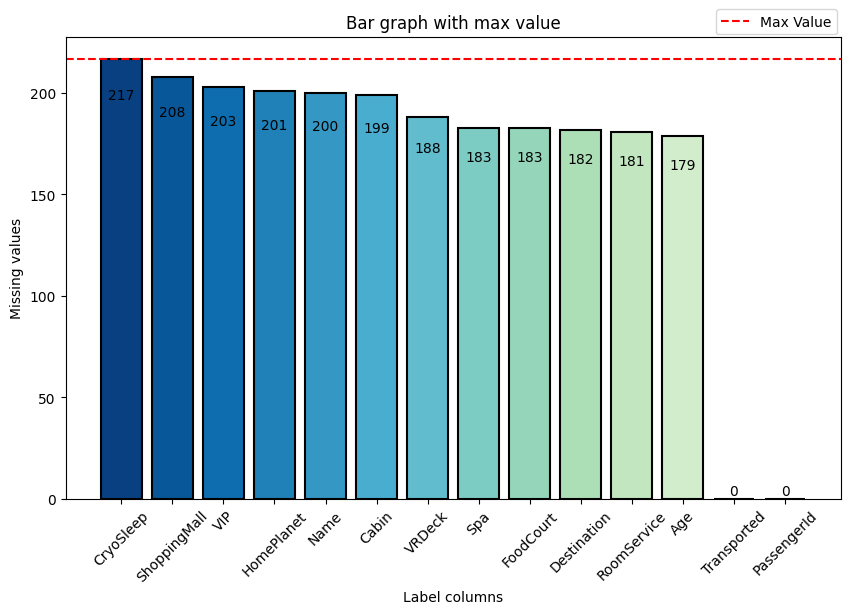

In [3]:
# blue color : plt.cm.GnBu_r
# purple color : plt.cm.Purples(np.linspace(0, 1, len(train.isna().sum().tolist())))

utilities_plot.plot_bar_graph(train.isna().sum().tolist(),
               train.isna().columns.tolist(),
               'Missing values', 'Label columns', color = plt.cm.GnBu_r, ax=None)
plt.show()

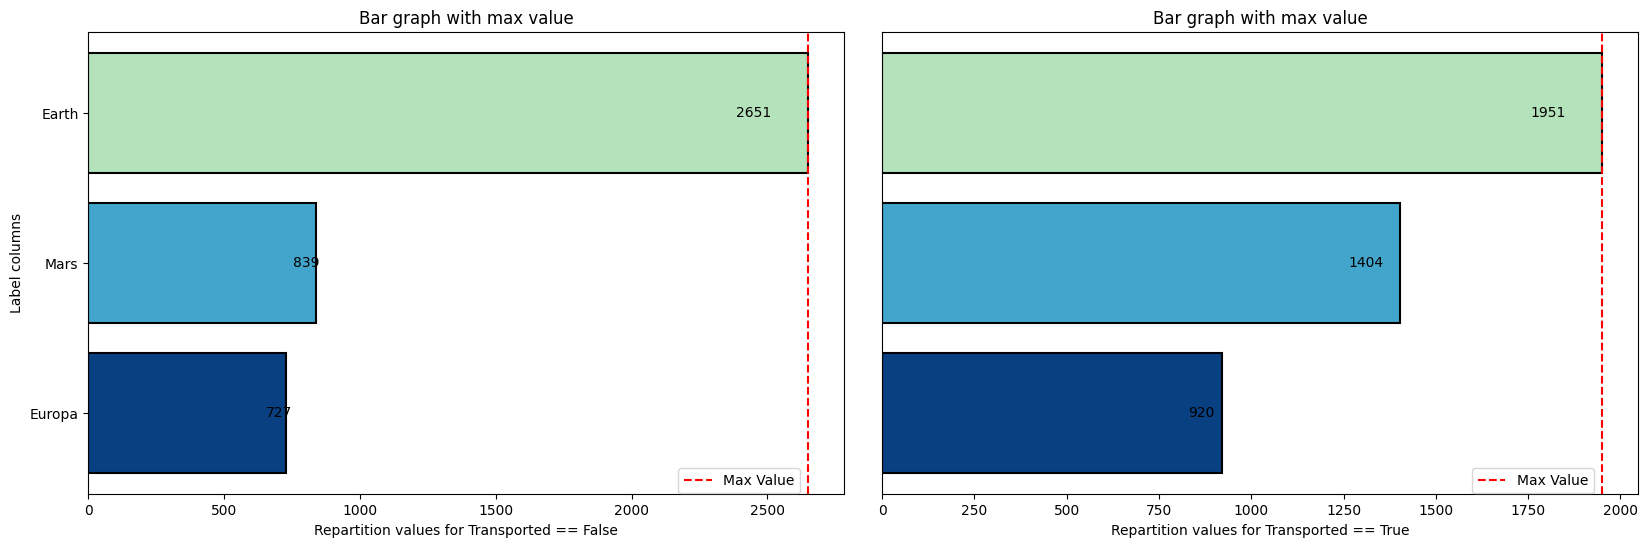

In [4]:
# We print the repartition of HomaPlanet depending on Transported or not

fig, axes = plt.subplots(1, 2, figsize=(20, 6))

ax0 = utilities_plot.plot_barh_graph(train[train['Transported'] == False].HomePlanet.value_counts().tolist(),
               train[train['Transported'] == False].HomePlanet.value_counts().index.tolist(),
               'Repartition values for Transported == False', 'Label columns', 
                color=plt.cm.GnBu_r, ax=axes[0])

ax1 = utilities_plot.plot_barh_graph(train[train['Transported'] == True].HomePlanet.value_counts().tolist(),
               train[train['Transported'] == True].HomePlanet.value_counts().index.tolist(),
               'Repartition values for Transported == True', 'Label columns', 
                color=plt.cm.GnBu_r, ax=axes[1])

ax1.set_ylabel('')
plt.setp(ax1.get_yticklabels(), visible = False)
plt.setp(ax1.get_yticklines(), visible = False)
plt.subplots_adjust(wspace=0.05)
plt.show()

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

<Axes: title={'center': 'Density of Age for Transported = True'}, xlabel='Age', ylabel='Density'>

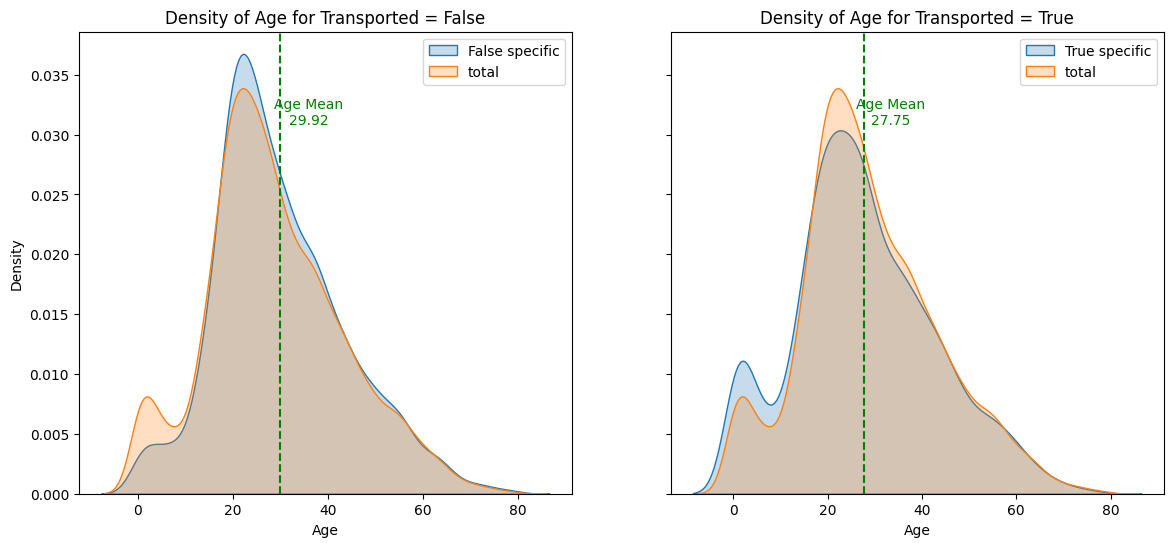

In [5]:
utilities_plot.display_density(train, 'Age', 'Transported')

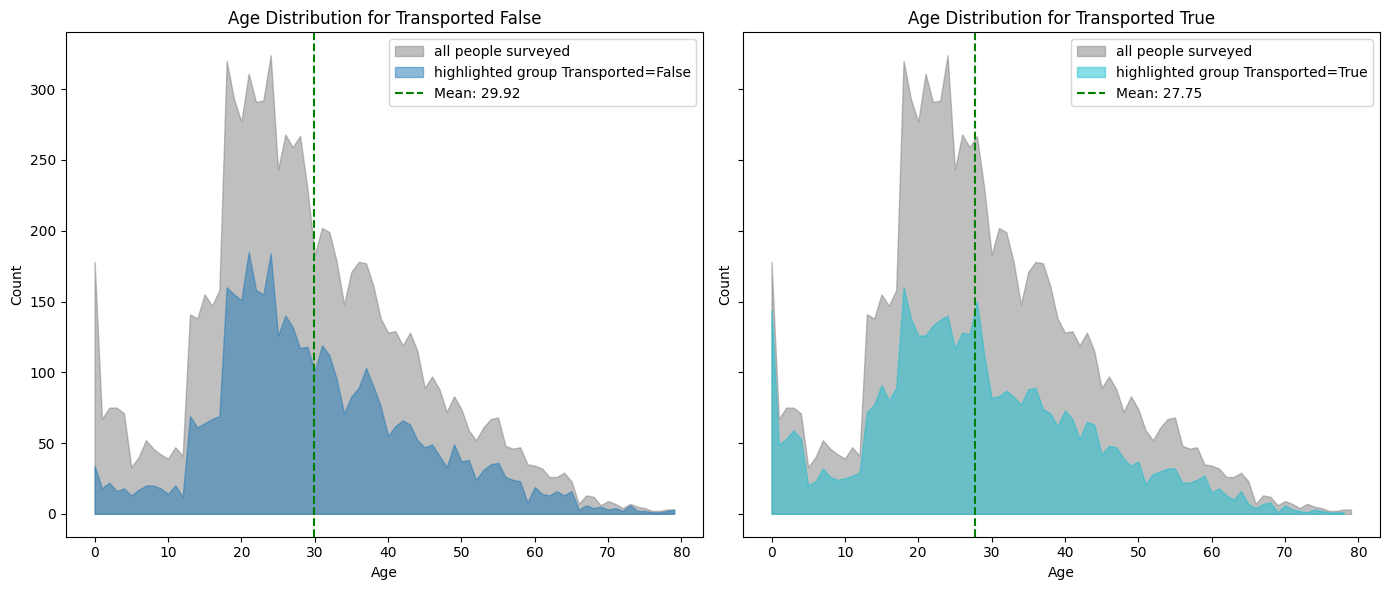

In [6]:
utilities_plot.display_classes_repartition(train, 'Age', 'Transported')

# We handle Cabin values

In [7]:
""" Preprocess of Cabin label """

print("empty value in train.Cabin : ", train.Cabin.isna().sum())
print("empty value in test.Cabin : ", test.Cabin.isna().sum())

def create_sub_cabin(df):
  """
  This function take a dataset and split the cabin value into 3 value :
  Example : B/0/P --> into --> [B, 0, P]
  And then we update the dataset with 3 new columns that contains the element of the list

  Args:
      df (pd.Dataset) : the dataset that contains that Cabin columns

  Returns:
      df : the dataset without the Cabin but with 3 new columns 'Cabin1', 'Cabin2' and 'Cabin3'
  """
  # we split Cabin values
  df['Cabin'] = df.Cabin.apply(lambda x : x.split('/') if pd.notnull(x) else x)

  #we create the 3 new columns
  df['Cabin1'] = df.Cabin.apply(lambda value : value[0] if isinstance(value, list) else value)
  df['Cabin2'] = df.Cabin.apply(lambda value : value[1] if isinstance(value, list) else value)
  df['Cabin3'] = df.Cabin.apply(lambda value : value[2] if isinstance(value, list) else value)

  df = df.drop(['Cabin'], axis = 1)

  return df

def preproccess_cabin(train, test):
  """
  This function take 2 test and train datasets and use the function create_sub_cabin to see
  which value are in common between the 2 datasets. This is important for the labelization, because
  if there is too many distinct value in test, it will raise an issue.

  Args:
      train (pd.Dataset) : the traindataset
      test (pd.Dataset) : the test dataset

  Returns:
      train : the dataset without Cabin2
      test : the dataset without Cabin2
  """
  train = create_sub_cabin(train)
  test = create_sub_cabin(test)
  diff1 = set(test.Cabin1.unique()) - set(train.Cabin1.unique())
  diff2 = set(test.Cabin2.unique()) - set(train.Cabin2.unique())
  diff3 = set(test.Cabin3.unique()) - set(train.Cabin3.unique())
  print("Nb of elements that are in test but not in train for cabine1:", len(diff1))
  print("Nb of elements that are in test but not in train for cabine2:", len(diff2))
  print("Nb of elements that are in test but not in train for cabine3:", len(diff3))
  print("we don't keep cabin2, because too many distinct values")
  train = train.drop(['Cabin2'], axis = 1)
  test = test.drop(['Cabin2'], axis = 1)

  return train, test

train, test = preproccess_cabin(train, test)

empty value in train.Cabin :  199
empty value in test.Cabin :  100
Nb of elements that are in test but not in train for cabine1: 0
Nb of elements that are in test but not in train for cabine2: 77
Nb of elements that are in test but not in train for cabine3: 0
we don't keep cabin2, because too many distinct values


# Main processing of train and test

In [8]:
def main(train, test):
  """
  This is the main function, which take the train and test, clean them and return them

  Args:
      train (pd.Dataset) : the traindataset
      test (pd.Dataset) : the test dataset

  Returns:
      train : the dataset processed and labelized
      test : the dataset processed and labelized
  """

  # We save PassengerId for the submission test
  PassengerId_test = test.PassengerId

  # We drop the non usefull label
  train = train.drop(['Name', 'PassengerId'], axis=1)
  test = test.drop(['Name', 'PassengerId'], axis=1)

  # We preprocess Cabin label
  train, test = preproccess_cabin(train, test)
  print('>---------------------------------------------------')
  print('Cabin1 and 3 created successfully !')
  print(('<---------------------------------------------------\n'))

  # We fill na with automatic function from preprocess_dataset
  print('>---------------------------------------------------')
  print('Missing values before process : ')
  train = utilities.fillna_process(train, False)
  test = utilities.fillna_process(test, False)
  print(('<---------------------------------------------------\n'))

  # We labelize
  to_labelize = [key for key in train if train[key].dtype == 'object' or train[key].dtype == 'category']
  encode = LabelEncoder()
  print('>---------------------------------------------------')
  print('labelization in process : {}'.format(to_labelize))
  for label in to_labelize:
    print('.', end='')
    # fit_transform on train label
    train[label] = encode.fit_transform(train[label])
    # only transform on test label
    test[label] = encode.transform(test[label])
  print('sucessfully done !')
  print(('<---------------------------------------------------\n'))

  return train, test, PassengerId_test

# Import datasets
train = pd.read_csv('/kaggle/input/spaceship-titanic-dataset/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic-dataset/test.csv')

train, test, PassengerId_test = main(train, test)

Nb of elements that are in test but not in train for cabine1: 0
Nb of elements that are in test but not in train for cabine2: 77
Nb of elements that are in test but not in train for cabine3: 0
we don't keep cabin2, because too many distinct values
>---------------------------------------------------
Cabin1 and 3 created successfully !
<---------------------------------------------------

>---------------------------------------------------
Missing values before process : 
<---------------------------------------------------

>---------------------------------------------------
labelization in process : ['HomePlanet', 'Destination', 'Cabin1', 'Cabin3']
....sucessfully done !
<---------------------------------------------------



/kaggle/usr/lib/utilities/utilities.py:319: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[key] = data[key].fillna(most_common)
/kaggle/usr/lib/utilities/utilities.py:319: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data[key] = data[key].fillna(most_common)
/kaggle/usr/lib/utilities/utilities.py:319: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasti

# Correlation matrix

correlation matrix :



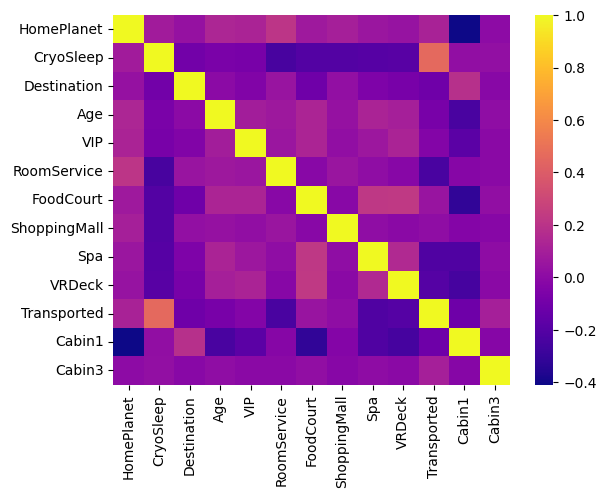

In [9]:
print("correlation matrix :" + "\n")
sb.heatmap(train.corr(), cmap='plasma')
plt.show()

# Predict model

In [10]:
# We split the train dataset into train and validation
from sklearn.model_selection import train_test_split

# we save label to predict
transported_train = train.Transported

# we drop the label to predict
train = train.drop(['Transported'], axis=1)

# we split the dataset
x_train, x_val, y_train, y_val = train_test_split(train,
                                                  transported_train,
                                                  test_size = 0.3,
                                                  random_state = 42)

# Catboost

In [11]:
from catboost import CatBoostClassifier

Cat = CatBoostClassifier(iterations=3000,
                        learning_rate=0.1,
                        depth=3,random_seed=0, verbose=0)

Cat.fit(x_train, y_train)

pred_cat = Cat.predict(x_val)

print("Accuracy : ",  accuracy_score(y_val, pred_cat))


Accuracy :  0.7910276073619632


# XGBoost

In [12]:
import xgboost as xgb
from xgboost import XGBClassifier

XGB = XGBClassifier(n_estimators=600,
                    max_depth=4,
                    learning_rate=0.04,
                    random_state=0)

XGB.fit(x_train, y_train)

predictions_xgb = XGB.predict(x_val)

print("précision accuracy : ",  accuracy_score(y_val, predictions_xgb))

pred = XGB.predict(test)

# Assuming test_preds contains your predictions
submission = pd.DataFrame({'PassengerId': PassengerId_test,
                           'Transported': pred})

# Save submission to a CSV file
submission.to_csv('submission.csv', index=False)

précision accuracy :  0.7952453987730062


# Decision Tree

précision accuracy :  0.7419478527607362


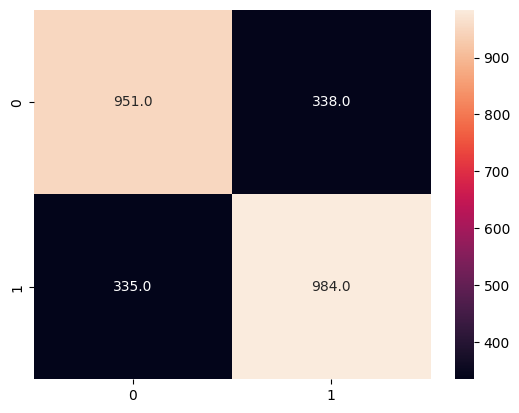

In [13]:
# Decision Tree :

model = DecisionTreeClassifier(criterion = 'entropy')
model.fit(x_train, y_train)

predictions = model.predict(x_val)

print("précision accuracy : ",  accuracy_score(y_val, predictions))

cm = confusion_matrix(y_val, predictions)
sb.heatmap(cm,annot = True,fmt = ".1f")
plt.show()

# Random Forest

précision accuracy :  0.7760736196319018


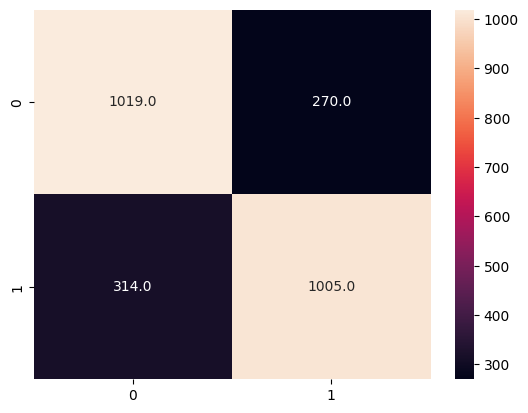

In [14]:
# random forest :

model1 = RandomForestClassifier(n_estimators = 100)

model1.fit(x_train, y_train)

predictions = model1.predict(x_val)

print("précision accuracy : ",  accuracy_score(y_val, predictions))

cm = confusion_matrix(y_val, predictions)
sb.heatmap(cm,annot = True,fmt = ".1f")
plt.show()



# Logistic Regression

In [15]:
# Logistic regression :

clf = LogisticRegression()
clf.fit(x_train, y_train)

pred = clf.predict(x_val)

accuracy_score(y_val, pred)

/opt/conda/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.7699386503067485

# We will fillna with the KNNImputer method

In [16]:
# We define the new main function adapt for KnnImputer
def main_knn(train, test):
  """
  This is the main function, which take the train and test, clean them and return them

  Args:
      train (pd.Dataset) : the traindataset
      test (pd.Dataset) : the test dataset

  Returns:
      train : the dataset processed and labelized
      test : the dataset processed and labelized
  """

  # We save PassengerId for the submission test
  PassengerId_test = test.PassengerId

  Transported = train.Transported
  train = train.drop(['Transported'], axis=1)

  # We drop the non usefull label
  train = train.drop(['Name', 'PassengerId'], axis=1)
  test = test.drop(['Name', 'PassengerId'], axis=1)

  # We preprocess Cabin label
  train, test = preproccess_cabin(train, test)
  print('>---------------------------------------------------')
  print('Cabin1 and 3 created successfully !')
  print(('<---------------------------------------------------\n'))

  # We fill na with automatic KNNImputer function from utilities
  print('>---------------------------------------------------')
  train, test = utilities.pre_knnimput(train, test)
  print('Missing values after process : ')
  print(train.isna().any())


  return train, test, PassengerId_test, Transported

# Import datasets
train = pd.read_csv('/kaggle/input/spaceship-titanic-dataset/train.csv')
test = pd.read_csv('/kaggle/input/spaceship-titanic-dataset/test.csv')

train_knn, test_knn, PassengerId_test, Transported = main_knn(train, test)

Nb of elements that are in test but not in train for cabine1: 0
Nb of elements that are in test but not in train for cabine2: 77
Nb of elements that are in test but not in train for cabine3: 0
we don't keep cabin2, because too many distinct values
>---------------------------------------------------
Cabin1 and 3 created successfully !
<---------------------------------------------------

>---------------------------------------------------
need labelize :  HomePlanet
need labelize :  CryoSleep
need labelize :  Destination
need labelize :  VIP
need labelize :  Cabin1
need labelize :  Cabin3
Missing values after process : 
HomePlanet      False
CryoSleep       False
Destination     False
Age             False
VIP             False
RoomService     False
FoodCourt       False
ShoppingMall    False
Spa             False
VRDeck          False
Cabin1          False
Cabin3          False
dtype: bool


# Predict model

In [17]:
# We split the train dataset into train and validation
from sklearn.model_selection import train_test_split

# we split the dataset
x_train_knn, x_val_knn, y_train_knn, y_val_knn = train_test_split(train_knn,
                                                  Transported,
                                                  test_size = 0.3,
                                                  random_state = 42)

# Comparison function between the 2 fillna method

In [18]:
def launch_model(model, x_train, y_train, x_val, y_val):
    
    model.fit(x_train, y_train)

    pred = model.predict(x_val)

    print('Accuracy for {} model'.format(model), accuracy_score(y_val, pred))
    return accuracy_score(y_val, pred)

In [19]:
models = [LogisticRegression(max_iter = 10000), 
          RandomForestClassifier(n_estimators = 100), 
          DecisionTreeClassifier(criterion = 'entropy'),
          XGBClassifier(),
         lgb.LGBMClassifier(), CatBoostClassifier(iterations=3000,
                        learning_rate=0.1,
                        depth=3,random_seed=0, verbose=0)]

for model in models:
    print('For KnnImputer method')
    score0 = launch_model(model, x_train_knn, y_train_knn, x_val_knn, y_val_knn)
    print('For Fillna method')
    score1 = launch_model(model, x_train, y_train, x_val, y_val)
    
    print('>-------------------------------------------------------<\n')

For KnnImputer method
Accuracy for LogisticRegression(max_iter=10000) model 0.7703220858895705
For Fillna method
Accuracy for LogisticRegression(max_iter=10000) model 0.7710889570552147
>-------------------------------------------------------<

For KnnImputer method
Accuracy for RandomForestClassifier() model 0.7891104294478528
For Fillna method
Accuracy for RandomForestClassifier() model 0.781058282208589
>-------------------------------------------------------<

For KnnImputer method
Accuracy for DecisionTreeClassifier(criterion='entropy') model 0.7377300613496932
For Fillna method
Accuracy for DecisionTreeClassifier(criterion='entropy') model 0.7496165644171779
>-------------------------------------------------------<

For KnnImputer method
Accuracy for XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=